In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [6]:
df = pd.read_csv('../Data/bank-additional-full.csv', sep =';')

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [8]:
print("\nTarget Variable Distribution:\n", df['y'].value_counts())


Target Variable Distribution:
 y
no     36548
yes     4640
Name: count, dtype: int64


In [9]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})

In [11]:
X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

In [20]:
numeric_features = ['age', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = [
    'job', 'marital', 'education', 'default',
    'housing', 'loan', 'contact', 'month', 'poutcome'
]

In [21]:
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
])

In [22]:
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(solver='liblinear'))  # 'liblinear' can handle smaller datasets well
])

logreg_pipeline.fit(X_train, y_train)
y_pred_log = logreg_pipeline.predict(X_test)

print("\n=== Logistic Regression Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))

# Get feature names after transformation
enc_cat_names = logreg_pipeline.named_steps['preprocessor'] \
                    .transformers_[1][1] \
                    .named_steps['onehot'] \
                    .get_feature_names_out(categorical_features)

all_feature_names = numeric_features + list(enc_cat_names)

# Extract coefficients
coef = logreg_pipeline.named_steps['logreg'].coef_[0]
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coef
}).sort_values(by='Coefficient', ascending=False)

print("\nLogistic Regression Coefficients (sorted):")
print(coef_df.head(10).to_string(index=False))  # Show top 10


=== Logistic Regression Results ===
Accuracy: 0.9090394108602412
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95     10965
           1       0.68      0.36      0.47      1392

    accuracy                           0.91     12357
   macro avg       0.80      0.67      0.71     12357
weighted avg       0.90      0.91      0.90     12357


Logistic Regression Coefficients (sorted):
             Feature  Coefficient
           month_mar     1.577440
            duration     1.130756
           month_oct     0.868223
           month_dec     0.789683
education_illiterate     0.755898
    poutcome_success     0.746793
           month_sep     0.675434
         job_student     0.615161
         job_retired     0.574501
   education_unknown     0.282452



=== Best Random Forest Params ===
{'rf__max_depth': None, 'rf__n_estimators': 100}
CV Best Accuracy: 0.9067668878513979

=== Random Forest Results ===
Accuracy: 0.9071781176661002
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     10965
           1       0.64      0.41      0.50      1392

    accuracy                           0.91     12357
   macro avg       0.78      0.69      0.72     12357
weighted avg       0.90      0.91      0.90     12357


Random Forest Feature Importances (Descending):
duration: 0.3418
age: 0.1377
campaign: 0.0568
pdays: 0.0479
poutcome_success: 0.0381
housing_yes: 0.0255
previous: 0.0206
contact_telephone: 0.0182
loan_yes: 0.0170
marital_married: 0.0149
month_mar: 0.0144
month_jun: 0.0142
month_may: 0.0138
month_oct: 0.0137
education_university.degree: 0.0134


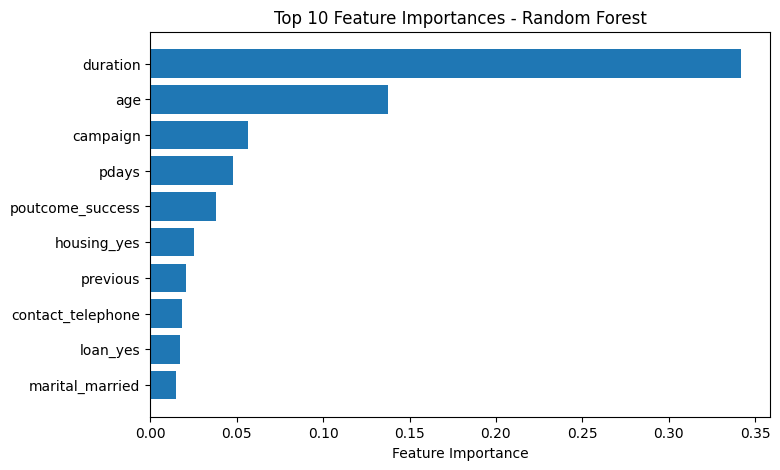

In [23]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

# Example: small grid search for demonstration
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [5, 10, None],
}
rf_search = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_search.fit(X_train, y_train)

print("\n=== Best Random Forest Params ===")
print(rf_search.best_params_)
print("CV Best Accuracy:", rf_search.best_score_)

# Final model
best_rf = rf_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("\n=== Random Forest Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Get feature importances
importances = best_rf.named_steps['rf'].feature_importances_
sorted_idx = np.argsort(importances)[::-1]

print("\nRandom Forest Feature Importances (Descending):")
for idx in sorted_idx[:15]:  # Show top 15 for brevity
    print(f"{all_feature_names[idx]}: {importances[idx]:.4f}")

# Optional: Quick bar chart of top 10
topN = 10
plt.figure(figsize=(8,5))
plt.barh(
    [all_feature_names[i] for i in sorted_idx[:topN]][::-1],
    importances[sorted_idx[:topN]][::-1]
)
plt.xlabel("Feature Importance")
plt.title("Top 10 Feature Importances - Random Forest")
plt.show()